# Práctico 1: Recomendación de Artistas

En este práctico trabajaremos con el conjuto de datos de [LastFM](https://grouplens.org/datasets/hetrec-2011/) para el desarrollo de un sistema de recomendación que, dado el nombre de un artista musical, devuelve una lista de artistas "similares".

Para el práctico utilizaremos el conjunto de datos de LastFM que consiguieron del [notebook de instalación](./instalacion.ipynb). Se recomienda leer el [Readme](http://files.grouplens.org/datasets/hetrec2011/hetrec2011-lastfm-readme.txt) de los datos para saber más sobre que información contiene cada archivo.

La idea del práctico es hacer un análisis muy sencillo del conjunto de datos y desarrollar un sistema de recomendación basado en filtrado colaborativo (usando Surpr!se), a partir de los datos existentes.

In [1]:
#paquetería...

import pandas as pd
import numpy as np


In [2]:
#artist_data...

artist_data = pd.read_csv('C:/Users/Flavio/Downloads/hetrec2011-lastfm-2k/artists.dat', sep = '\t')
display(artist_data.head())
artist_data.shape


,id,name,url,pictureURL
0,1,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,http://userserve-ak.last.fm/serve/252/10808.jpg
1,2,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,http://userserve-ak.last.fm/serve/252/3052066.jpg
2,3,Carpathian Forest,http://www.last.fm/music/Carpathian+Forest,http://userserve-ak.last.fm/serve/252/40222717...
3,4,Moi dix Mois,http://www.last.fm/music/Moi+dix+Mois,http://userserve-ak.last.fm/serve/252/54697835...
4,5,Bella Morte,http://www.last.fm/music/Bella+Morte,http://userserve-ak.last.fm/serve/252/14789013...


(17632, 4)

In [3]:
#user_artist_plays...

user_artist_plays = pd.read_csv('C:/Users/Flavio/Downloads/hetrec2011-lastfm-2k/user_artists.dat', sep = '\t')
display(user_artist_plays.head())
user_artist_plays.shape


,userID,artistID,weight
0,2,51,13883
1,2,52,11690
2,2,53,11351
3,2,54,10300
4,2,55,8983


(92834, 3)

## Ejercicio 1 - Análisis Exploratorio de Datos

En esta primera parte deberán hacer un análisis exploratorio de los datos, aprovechando toda la información brindada por el conjunto. A partir de eso podrán tener mayor idea de qué tipo de datos estarán enfrentando (describe o hist).

Algunas preguntas para responder:
- ¿Cuáles son los artistas que fueron más escuchados?
- ¿Cómo es la distribución de cantidad de listens por user?
- ¿Es posible ver el género más escuchado?

In [4]:
#¿Cuáles son los artistas que fueron más escuchados?

artist_dicc = pd.Series(artist_data.name.values, index = artist_data.id).to_dict()

top10_artist = pd.pivot_table(user_artist_plays, index = ['artistID'], values = ['weight'], aggfunc = sum, fill_value = 0).reset_index().sort_values(by = 'weight', ascending = False).rename(columns = {'weight':'repro'}).head(10)
top10_artist.insert(1, 'name', top10_artist.artistID.map(artist_dicc))

display(top10_artist)
top10_artist.shape


,artistID,name,repro
283,289,Britney Spears,2393140
66,72,Depeche Mode,1301308
83,89,Lady Gaga,1291387
286,292,Christina Aguilera,1058405
492,498,Paramore,963449
61,67,Madonna,921198
282,288,Rihanna,905423
695,701,Shakira,688529
221,227,The Beatles,662116
294,300,Katy Perry,532545


(10, 3)

,count,mean,std,min,25%,50%,75%,max
weight,1892.0,36566.582981,48744.552394,3.0,9742.25,21573.0,42963.75,480039.0


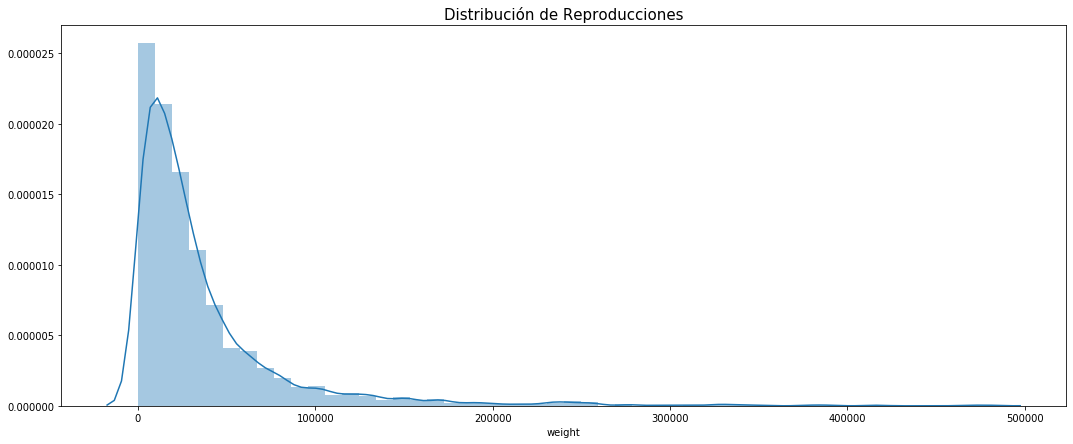

In [6]:
#¿Cómo es la distribución de cantidad de listens por user?

display(pd.pivot_table(user_artist_plays, index = ['userID'], values = ['weight'], aggfunc = sum, fill_value = 0).describe().T)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize = (18, 7))

plt.title('Distribución de Reproducciones', fontsize = 15)
sns.distplot(pd.pivot_table(user_artist_plays, index = ['userID'], values = ['weight'], aggfunc = sum, fill_value = 0).weight)

plt.show()


In [7]:
#¿Es posible ver el género más escuchado?

tags_dat = pd.read_csv('C:/Users/Flavio/Downloads/hetrec2011-lastfm-2k/tags.dat', sep = '\t', encoding = 'latin-1')
tags_dicc = pd.Series(tags_dat.tagValue.values, index = tags_dat.tagID).to_dict()

user_taggedartists_dat = pd.read_csv('C:/Users/Flavio/Downloads/hetrec2011-lastfm-2k/user_taggedartists.dat', sep = '\t')

top10_tag = pd.DataFrame(user_taggedartists_dat.tagID.value_counts())[0:10].reset_index().rename(columns = {'index':'id', 'tagID':'repro'})
top10_tag.insert(1, 'name', top10_tag.id.map(tags_dicc))

top10_tag


,id,name,repro
0,73,rock,7503
1,24,pop,5418
2,79,alternative,5251
3,18,electronic,4672
4,81,indie,4458
5,130,female vocalists,4228
6,25,80s,2791
7,39,dance,2739
8,78,alternative rock,2631
9,192,classic rock,2287


## Ejercicio 2 - Matriz de Usuario-Contenido

En este ejercicio, a partir del conjunto de datos, deberán generar una matriz de usuario-contenido. Tengan en cuenta que los ratings, en este caso, son implícitos, puesto que se dan a partir de la cantidad de veces que un usuario escuchó a cierto artista.

In [8]:
#mapeamos tabla user_artist_plays con nombre del artista...

all_artist_dicc = pd.Series(artist_data.name.values, index = artist_data.id).to_dict()

user_artist_plays_map = user_artist_plays.copy()
user_artist_plays_map.insert(2, 'name', user_artist_plays_map.artistID.map(all_artist_dicc))

user_artist_plays_map


,userID,artistID,name,weight
0,2,51,Duran Duran,13883
1,2,52,Morcheeba,11690
2,2,53,Air,11351
3,2,54,Hooverphonic,10300
4,2,55,Kylie Minogue,8983
...,...,...,...,...
92829,2100,18726,Nyktalgia,337
92830,2100,18727,Atsakau niekadA,297
92831,2100,18728,Domantas Razauskas,281
92832,2100,18729,Atalyja,280


In [9]:
#nombres únicos...

print(user_artist_plays_map.name.nunique())
print(user_artist_plays_map.artistID.nunique())


17632
17632


In [10]:
#pivoteamos user_artist_plays_map para generar una matriz usuario-contenido (dispersa)...

mtrx_user_artist_plays = pd.pivot_table(user_artist_plays_map, index = ['userID'], columns = ['artistID'], values = ['weight'], aggfunc = sum, fill_value = 0)
mtrx_user_artist_plays


weight                                                        ...  \
artistID  1     2     3     4     5     6     7     8     9     10     ...   
userID                                                                 ...   
2             0     0     0     0     0     0     0     0     0     0  ...   
3             0     0     0     0     0     0     0     0     0     0  ...   
4             0     0     0     0     0     0     0     0     0     0  ...   
5             0     0     0     0     0     0     0     0     0     0  ...   
6             0     0     0     0     0     0     0     0     0     0  ...   
...         ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
2095          0     0     0     0     0     0     0     0     0     0  ...   
2096          0     0     0     0     0     0     0     0     0     0  ...   
2097          0     0     0     0     0     0     0     0     0     0  ...   
2099          0     0     0     0     0     0     0     0     0     0  ...   
2100          0     0   408     0     0   404     0     0     0     0  ...   

                                                                      
artistID 18736 18737 18738 18739 18740 18741 18742 18743 18744 18745  
userID                                                                
2            0     0     0     0     0     0     0     0     0     0  
3            0     0     0     0     0     0     0     0     0     0  
4            0     0     0     0     0     0     0     0     0     0  
5            0     0     0     0     0     0     0     0     0     0  
6            0     0     0     0     0     0     0     0     0     0  
...        ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  
2095         0     0     0     0     0     0     0     0     0     0  
2096         0     0     0     0     0     0     0     0     0     0  
2097         0     0     0     0     0     0     0     0     0     0  
2099         0     0     0     0     0     0     0     0     0     0  
2100         0     0     0     0     0     0     0     0     0     0  

[1892 rows x 17632 columns]

In [11]:
#acomodamos las columnas...

mtrx_user_artist_plays.columns = all_artist_dicc.values()
#mtrx_user_artist_plays.reset_index(inplace = True)

mtrx_user_artist_plays


,MALICE MIZER,Diary of Dreams,Carpathian Forest,Moi dix Mois,Bella Morte,Moonspell,Marilyn Manson,DIR EN GREY,Combichrist,Grendel,...,LOSTFREEQ,Ciccone Youth,Cubanate,Apollo 440,Die Krupps,Diamanda Galás,Aya RL,Coptic Rain,Oz Alchemist,Grzegorz Tomczak
userID,,,,,,,,,,,,,,,,,,,,,
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2095,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2096,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2097,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Ejercicio 3 - Entrenamiento del algoritmo de recomendación

Utilizando las herramientas brindadas por Surpr!se, entrenen varios modelos de sistemas de recomendación basados en filtrado colaborativo a partir de su matriz de usuario-contenido. Recuerden tener en cuenta lo aprendido en la diplomatura a la hora de evaluar y validar el modelo.

Si necesitan inspiración, les recomiendo revisar [este notebook con información de como entrenar un sistema de recomendación con Surpr!se](https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/Building%20Recommender%20System%20with%20Surprise.ipynb).

In [12]:
#...

from surprise import Dataset, Reader, KNNWithMeans
from surprise.accuracy import rmse
from surprise.model_selection import cross_validate, train_test_split

reader = Reader(rating_scale = (user_artist_plays.weight.min(), user_artist_plays.weight.max()))

ratings = Dataset.load_from_df(user_artist_plays[['userID', 'artistID', 'weight']], reader)


In [13]:
#...

ratings_train, ratings_test = train_test_split(ratings, test_size = 0.2)

model = KNNWithMeans(k = 5).fit(ratings_train)
predictions = model.test(ratings_test)

print("RMSE on test: {:.4f}".format(rmse(predictions, verbose = False)))


Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE on test: 4598.9266


In [14]:
#

model = KNNWithMeans(k = 5, verbose = False)
cross_validated_metrics = cross_validate(model, ratings, measures = ['RMSE', 'MAE'], cv = 5, verbose = True)


Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    3570.69424383.00605082.94544682.92863937.80684331.4762533.7874
MAE (testset)     779.8527826.4600837.5187826.9944825.8865819.342420.2082 
Fit time          0.73    0.75    0.75    0.76    0.89    0.78    0.06    
Test time         1.59    1.47    1.47    1.65    1.73    1.58    0.10    


## Ejercicio 4 - Sistema de recomendación

A partir del mejor modelo de recomendación que hayan sugerido en el caso anterior, y utilizando los datos del archivo `artist.dat`, armar un sistema de recomendación sencillo que, dado un nombre de un artista, devuelva el top 10 de artistas más similares.

La idea es que el sistema tome el nombre de un artista y devuelva el nombre de otros artistas (no simplemente tomar y devolver IDs). Se recomienda [revisar este notebook para inspiración (ver el paso número 5)](https://github.com/topspinj/pydata-workshop/blob/master/tutorial.ipynb).

In [17]:
#similitud entre artistas...

from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(mtrx_user_artist_plays, mtrx_user_artist_plays)
cosine_sim


array([[1.00000000e+00, 0.00000000e+00, 1.44786308e-01, ...,
        8.21344651e-02, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 3.18100148e-04, 0.00000000e+00],
       [1.44786308e-01, 0.00000000e+00, 1.00000000e+00, ...,
        6.59085242e-01, 0.00000000e+00, 0.00000000e+00],
       ...,
       [8.21344651e-02, 0.00000000e+00, 6.59085242e-01, ...,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 3.18100148e-04, 0.00000000e+00, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [18]:
# Completar...

def artist_finder(artist):
    return artist_data[artist_data['name'].str.contains(artist)]['name'].tolist()

artist_idx = dict(zip(artist_data['name'], list(artist_data.index)))
name = artist_finder('Factory')[0]
n_recommendations = 10

idx = artist_idx[name]
sim_scores = list(enumerate(cosine_sim[idx]))
sim_scores = sorted(sim_scores, key = lambda x: x[1], reverse = True)
sim_scores = sim_scores[1:(n_recommendations + 1)]
similar_artist = [i[0] for i in sim_scores]

print('Recomendaciones para {}:'.format(name))
for artist in artist_data['name'].iloc[similar_artist]:
    print('\t{}'.format(artist))


Recomendaciones para Fiction Factory:
	Yellow Magic Orchestra
	Jazzanova
	Gary Numan
	Darkest Hour
	T.I.
	VAST
	Angie Stone
	Elmore James
	Chainsaw Disaster
	Kevin Johansen
